In [1]:
from matplotlib import pyplot as plt

%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 7.5
# 用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['figure.autolayout'] = True
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [2]:
import numpy as np
import pandas as pd
import pylatex
pd.set_option('precision', 2)

from calculate_increases import calculate_increases
from line_chart_with_multiple_lines import line_chart_with_multiple_lines
from grouped_bar_chart import grouped_bar_chart
from parse_data import *

In [3]:
benchmark_max_stack_usages = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('benchmark_max_stack_usages', 'stack_size'),
    'max_stack_usage',
    True
)

benchmark_instruction_counts = parse_profile_data_in_directory_to_dataframe(
    parse_benchmark_instruction_counts_directory('benchmark_instruction_counts'),
    'instruction_count',
    True
)

benchmark_writes_on_hottest_stack_addresses = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('benchmark_writes_on_hottest_stack_addresses', 'writes'),
    'writes_on_hottest_stack_address',
    True
)

max_number_of_stack_frames_on_a_stack_address = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('max_number_of_stack_frames_on_a_stack_address', 'number_of_stack_frames'),
    'max_number_of_stack_frames_on_a_stack_address',
    True
)

writes_on_hottest_address_in_stack_frames = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('writes_on_hottest_address_in_stack_frames', 'writes'),
    'writes_on_hottest_address_in_stack_frames',
    True
)

In [4]:
import re

In [5]:
def f(types_of_benchmarks):
    recursion_depth_limit_benchmark_type_pattern = re.compile(r'new_loop2recursion-recursion_depth_limit-(\d+)')
    for benchmark_type in types_of_benchmarks:
        match = recursion_depth_limit_benchmark_type_pattern.match(benchmark_type)
        if match:
            recursion_depth_limit_string, *_ = match.groups()
            recursion_depth_limit = int(recursion_depth_limit_string)
            yield recursion_depth_limit

recursion_depth_limit_list = list(f(benchmark_max_stack_usages['executable_type'].unique()))
recursion_depth_limit_list.sort()
recursion_depth_limit_list

[8, 16, 32, 64]

In [6]:
recursion_depth_limit_executable_type_renaming = {
    f'new_loop2recursion-recursion_depth_limit-{recursion_depth_limit}': f'{recursion_depth_limit:02}'
    for recursion_depth_limit in recursion_depth_limit_list
}

recursion_depth_limit_executable_type_renaming['new_loop2recursion'] = 'Unlimited'

recursion_depth_limit_executable_type_renaming

{'new_loop2recursion-recursion_depth_limit-8': '08',
 'new_loop2recursion-recursion_depth_limit-16': '16',
 'new_loop2recursion-recursion_depth_limit-32': '32',
 'new_loop2recursion-recursion_depth_limit-64': '64',
 'new_loop2recursion': 'Unlimited'}

In [7]:
recursion_depth_limit_benchmark_max_stack_usages = benchmark_max_stack_usages[
    benchmark_max_stack_usages['executable_type'].isin(
        recursion_depth_limit_executable_type_renaming
    )
].replace(
    to_replace=recursion_depth_limit_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

recursion_depth_limit_benchmark_max_stack_usages

,executable_type,benchmark,max_stack_usage
225,08,average,6.25e+05
227,16,average,6.25e+05
234,32,average,6.27e+05
223,64,average,6.30e+05
236,Unlimited,average,4.49e+06
...,...,...,...
58,08,susan,3.72e+05
84,16,susan,3.72e+05
175,32,susan,3.74e+05
32,64,susan,3.83e+05


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Maximum Stack Usage'>)

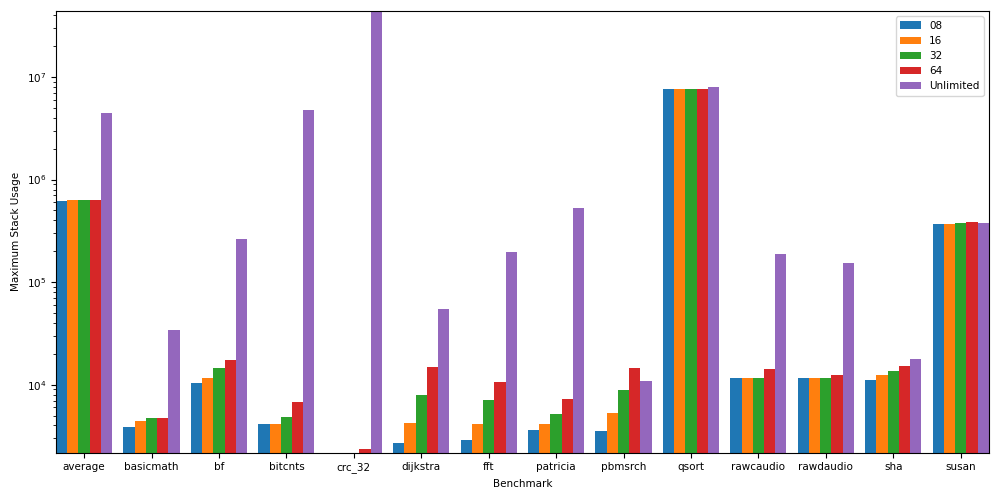

In [8]:
grouped_bar_chart(
    groups=recursion_depth_limit_benchmark_max_stack_usages['benchmark'].unique(),
    labels=recursion_depth_limit_executable_type_renaming.values(),
    data_by_label = (
        recursion_depth_limit_benchmark_max_stack_usages[
            recursion_depth_limit_benchmark_max_stack_usages['executable_type'] == recursion_depth_limit_executable_type
        ]['max_stack_usage']
        for recursion_depth_limit_executable_type in recursion_depth_limit_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Maximum Stack Usage',
    log=True
)

In [9]:
_[0].savefig('maximum_stack_usages_under_different_recursion_depth_limits.pdf')

In [10]:
maximum_stack_usages_under_different_recursion_depth_limits = calculate_increases(
    recursion_depth_limit_benchmark_max_stack_usages,
    'Unlimited',
    [
        f'{recursion_depth_limit:02}' for recursion_depth_limit in recursion_depth_limit_list
    ],
    'max_stack_usage',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in recursion_depth_limit_executable_type_renaming.values()
    },
    caption='Maximum Stack Usages Under Different Recursion Depth Limits',
    label='table:maximum_stack_usages_under_different_recursion_depth_limits',
    index=False
)

print(maximum_stack_usages_under_different_recursion_depth_limits)

\begin{table}
\centering
\caption{Maximum Stack Usages Under Different Recursion Depth Limits}
\label{table:maximum_stack_usages_under_different_recursion_depth_limits}
\begin{tabular}{lrrrrr}
\toprule
benchmark &  Unlimited & 08 Change & 16 Change & 32 Change & 64 Change \\
\midrule
  average &   4.49e+06 &   -86.10\% &   -86.09\% &   -86.05\% &   -85.99\% \\
basicmath &   3.38e+04 &   -88.64\% &   -86.88\% &   -86.13\% &   -86.13\% \\
       bf &   2.62e+05 &   -96.08\% &   -95.54\% &   -94.47\% &   -93.34\% \\
  bitcnts &   4.80e+06 &   -99.91\% &   -99.91\% &   -99.90\% &   -99.86\% \\
   crc\_32 &   4.38e+07 &  -100.00\% &  -100.00\% &  -100.00\% &   -99.99\% \\
 dijkstra &   5.47e+04 &   -95.08\% &   -92.33\% &   -85.54\% &   -72.90\% \\
      fft &   1.97e+05 &   -98.52\% &   -97.88\% &   -96.37\% &   -94.60\% \\
 patricia &   5.26e+05 &   -99.31\% &   -99.21\% &   -99.02\% &   -98.63\% \\
  pbmsrch &   1.08e+04 &   -67.65\% &   -51.11\% &   -18.02\% &    33.68\% \\
    qsort & 

In [11]:
recursion_depth_limit_benchmark_instruction_counts = benchmark_instruction_counts[
    benchmark_instruction_counts['executable_type'].isin(
        recursion_depth_limit_executable_type_renaming
    )
].replace(
    to_replace=recursion_depth_limit_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

recursion_depth_limit_benchmark_instruction_counts

,executable_type,benchmark,instruction_count
225,08,average,6.93e+07
227,16,average,6.83e+07
234,32,average,6.78e+07
223,64,average,6.77e+07
236,Unlimited,average,5.90e+07
...,...,...,...
58,08,susan,8.62e+07
84,16,susan,8.36e+07
175,32,susan,8.36e+07
32,64,susan,8.36e+07


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Instruction Count'>)

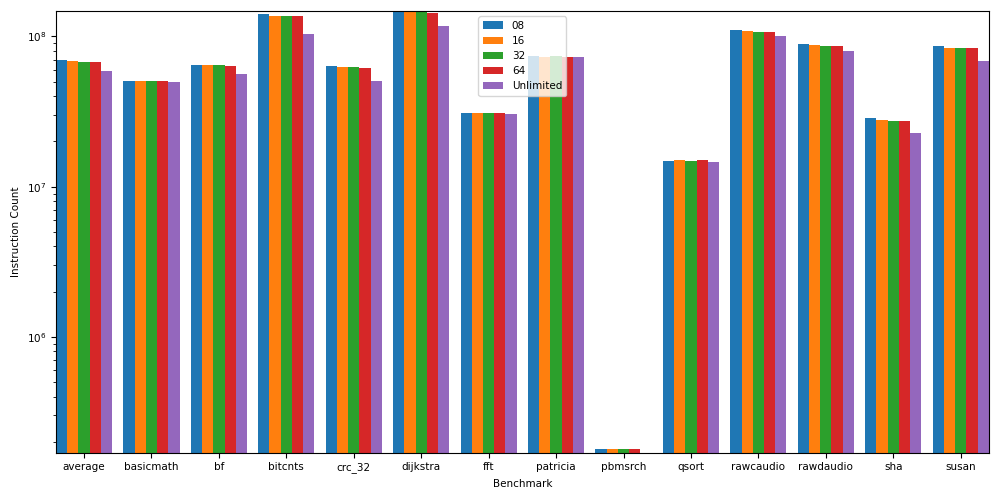

In [12]:
grouped_bar_chart(
    groups=recursion_depth_limit_benchmark_instruction_counts['benchmark'].unique(),
    labels=recursion_depth_limit_executable_type_renaming.values(),
    data_by_label = (
        recursion_depth_limit_benchmark_instruction_counts[
            recursion_depth_limit_benchmark_instruction_counts['executable_type'] == recursion_depth_limit_executable_type
        ]['instruction_count']
        for recursion_depth_limit_executable_type in recursion_depth_limit_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Instruction Count',
    log=True
)

In [13]:
_[0].savefig('instruction_counts_under_different_recursion_depth_limits.pdf')

In [14]:
instruction_counts_under_different_recursion_depth_limits = calculate_increases(
    recursion_depth_limit_benchmark_instruction_counts,
    'Unlimited',
    [
        f'{recursion_depth_limit:02}' for recursion_depth_limit in recursion_depth_limit_list
    ],
    'instruction_count',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in recursion_depth_limit_executable_type_renaming.values()
    },
    caption='Instruction Counts Under Different Recursion Depth Limits',
    label='table:instruction_counts_under_different_recursion_depth_limits',
    index=False
)

print(instruction_counts_under_different_recursion_depth_limits)

\begin{table}
\centering
\caption{Instruction Counts Under Different Recursion Depth Limits}
\label{table:instruction_counts_under_different_recursion_depth_limits}
\begin{tabular}{lrrrrr}
\toprule
benchmark &  Unlimited & 08 Change & 16 Change & 32 Change & 64 Change \\
\midrule
  average &   5.90e+07 &    17.50\% &    15.79\% &    15.05\% &    14.82\% \\
basicmath &   4.97e+07 &     1.57\% &     1.46\% &     1.42\% &     1.42\% \\
       bf &   5.62e+07 &    15.45\% &    14.53\% &    14.07\% &    13.61\% \\
  bitcnts &   1.04e+08 &    36.42\% &    32.98\% &    31.24\% &    31.12\% \\
   crc\_32 &   5.07e+07 &    25.29\% &    23.44\% &    22.51\% &    22.05\% \\
 dijkstra &   1.17e+08 &    26.06\% &    24.52\% &    23.75\% &    23.29\% \\
      fft &   3.05e+07 &     1.84\% &     1.73\% &     1.68\% &     1.66\% \\
 patricia &   7.24e+07 &     1.76\% &     1.44\% &     1.56\% &     1.44\% \\
  pbmsrch &   1.70e+05 &     4.93\% &     4.89\% &     4.88\% &     4.87\% \\
    qsort &   1.

In [15]:
recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses = benchmark_writes_on_hottest_stack_addresses[
    benchmark_writes_on_hottest_stack_addresses['executable_type'].isin(
        recursion_depth_limit_executable_type_renaming
    )
].replace(
    to_replace=recursion_depth_limit_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses

,executable_type,benchmark,writes_on_hottest_stack_address
225,08,average,253315.08
227,16,average,189150.85
234,32,average,161817.38
223,64,average,145674.31
236,Unlimited,average,128654.85
...,...,...,...
58,08,susan,139568.00
84,16,susan,68648.00
175,32,susan,37212.00
32,64,susan,17873.00


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Writes on Hottest Stack Address'>)

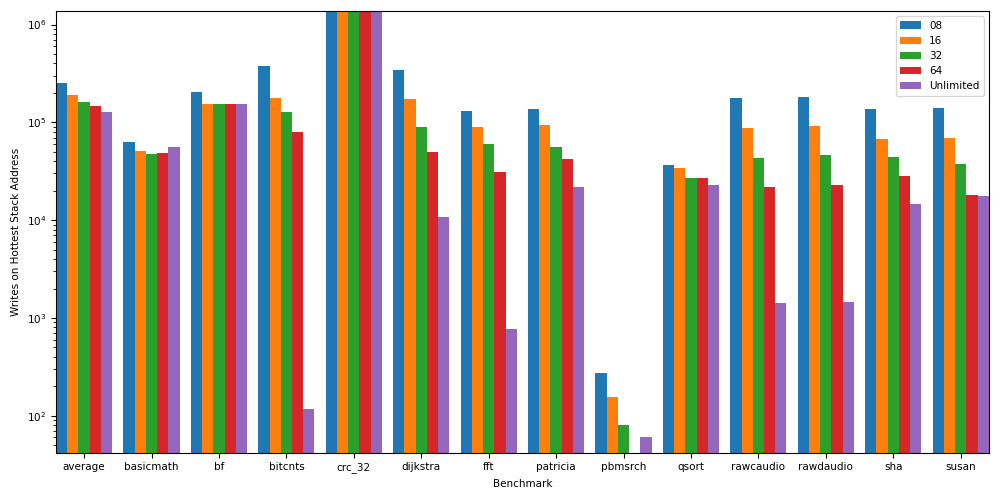

In [16]:
grouped_bar_chart(
    groups=recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses['benchmark'].unique(),
    labels=recursion_depth_limit_executable_type_renaming.values(),
    data_by_label = (
        recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses[
            recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses['executable_type'] == recursion_depth_limit_executable_type
        ]['writes_on_hottest_stack_address']
        for recursion_depth_limit_executable_type in recursion_depth_limit_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Writes on Hottest Stack Address',
    log=True
)

In [17]:
_[0].savefig('writes_on_hottest_stack_address_under_different_recursion_depth_limits.pdf')

In [18]:
writes_on_hottest_stack_address_under_different_recursion_depth_limits = calculate_increases(
    recursion_depth_limit_benchmark_writes_on_hottest_stack_addresses,
    'Unlimited',
    [
        f'{recursion_depth_limit:02}' for recursion_depth_limit in recursion_depth_limit_list
    ],
    'writes_on_hottest_stack_address',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in recursion_depth_limit_executable_type_renaming.values()
    },
    caption='Writes on Hottest Stack Address Under Different Recursion Depth Limits',
    label='table:writes_on_hottest_stack_address_under_different_recursion_depth_limits',
    index=False
)

print(writes_on_hottest_stack_address_under_different_recursion_depth_limits)

\begin{table}
\centering
\caption{Writes on Hottest Stack Address Under Different Recursion Depth Limits}
\label{table:writes_on_hottest_stack_address_under_different_recursion_depth_limits}
\begin{tabular}{lrrrrr}
\toprule
benchmark &  Unlimited &   08 Change &   16 Change &   32 Change &  64 Change \\
\midrule
  average &   1.29e+05 &      96.90\% &      47.02\% &      25.78\% &     13.23\% \\
basicmath &   5.60e+04 &      12.16\% &      -9.82\% &     -14.63\% &    -12.60\% \\
       bf &   1.56e+05 &      30.64\% &       0.00\% &       0.00\% &      0.00\% \\
  bitcnts &   1.18e+02 & 317,711.86\% & 150,893.22\% & 107,110.17\% & 67,490.68\% \\
   crc\_32 &   1.37e+06 &       0.00\% &       0.00\% &       0.00\% &      0.00\% \\
 dijkstra &   1.07e+04 &   3,122.34\% &   1,532.07\% &     736.83\% &    363.52\% \\
      fft &   7.76e+02 &  16,612.50\% &  11,421.01\% &   7,659.79\% &  3,895.49\% \\
 patricia &   2.18e+04 &     530.03\% &     327.99\% &     159.89\% &     92.65\% \\
  pbm